In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import gym
import torch
import torch.nn as nn
import torch.functional as F
from matplotlib import pyplot as plt
import pickle 
import imageio 

### BC Policy with MSE loss

#### Prepare data

In [2]:
data_path="expert_data/Pendulum-v1_10_-130.pkl"

In [3]:
with open(data_path, "rb") as f:
    data_good = pickle.load(f)
print('expert data loaded')

data_good=data_good[:20]

good_obs=[]
good_acts=[] 
for traj in data_good: 
    s,a,r=traj   
    good_obs.append(s)
    good_acts.append(a) 

states=np.vstack(good_obs)
actions=np.vstack(good_acts)
print('X:',states.shape,' y:', actions.shape)

expert data loaded
X: (2000, 3)  y: (2000, 1)


In [4]:
data_loader = torch.utils.data.DataLoader( list(zip(states, actions)), batch_size=64, shuffle=True)

batch=next(iter(data_loader))
states,actions = batch
states.shape,actions.shape

(torch.Size([64, 3]), torch.Size([64, 1]))

In [5]:
action_dim=actions.shape[1]
state_dim=states.shape[1]
print(state_dim, action_dim)

3 1


#### Train Model

In [6]:
class MLP(nn.Module):
    def __init__(self, input_dim, size=32):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim,size),
            nn.ReLU(), 
            nn.Linear(size,size),
            nn.ReLU() 
        )
    def forward(self,x):
        x = self.net(x)
        return x
    
class RegNet(MLP):
    def __init__(self, input_dim , size, action_dim):
        super(RegNet, self).__init__(input_dim, size)
        self.decoder = nn.Linear(size, action_dim)
    def forward(self,x):
        x = self.net(x)
        x = self.decoder(x)
        return x

In [7]:
model = RegNet(state_dim, 32, action_dim)
criterion = nn.MSELoss()
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [8]:
loss_list = []
test_loss = []
batch_size = 256
n_epoch = 1_000
 
for itr in range(0, n_epoch+1):
    total_loss = 0
    b=0
    for batch_states, batch_actions in data_loader: 
        y_pred = model(batch_states)
        loss   = criterion(y_pred, batch_actions) 
        total_loss += loss.item() 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        b += 1 
        
        loss_list.append(loss.item())
        
    if itr % (n_epoch//20)==0:
        print(f'Epoch {itr} Loss: {total_loss/b:.3f}')

Epoch 0 Loss: 0.328
Epoch 50 Loss: 0.075
Epoch 100 Loss: 0.040
Epoch 150 Loss: 0.037
Epoch 200 Loss: 0.027
Epoch 250 Loss: 0.028
Epoch 300 Loss: 0.017
Epoch 350 Loss: 0.024
Epoch 400 Loss: 0.021
Epoch 450 Loss: 0.023
Epoch 500 Loss: 0.015
Epoch 550 Loss: 0.013
Epoch 600 Loss: 0.015
Epoch 650 Loss: 0.015
Epoch 700 Loss: 0.019
Epoch 750 Loss: 0.011
Epoch 800 Loss: 0.010
Epoch 850 Loss: 0.010
Epoch 900 Loss: 0.016
Epoch 950 Loss: 0.012
Epoch 1000 Loss: 0.008


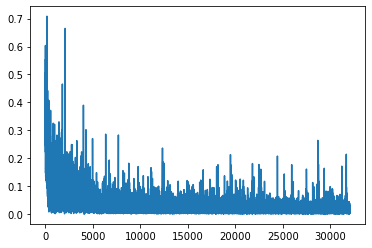

In [9]:
plt.plot(loss_list)

In [10]:
train_x=torch.tensor(states, dtype=torch.float)
train_y=torch.tensor(actions, dtype=torch.float)

In [11]:
yhat=model(train_x).detach().numpy()
score = 1 - ( (actions - yhat )**2 ).sum() /( (actions - actions.mean() )**2 ).sum()
print('regression score: ', score)

regression score:  tensor(0.9850)


#### Rollout

In [12]:
env_name='Pendulum-v1'

In [13]:
def play_an_episode(env_name, model, video_path=None, max_steps=1000):
    video_writer=None 
    if video_path is not None:
        print(f'Saving video to {video_path}')
        video_writer = imageio.get_writer(video_path, fps=20)
        env=gym.make(env_name, render_mode='rgb_array')
    else:
        env=gym.make(env_name)

    obs,_=env.reset()
    rewards=0
    step=0
    for _ in range(max_steps):
        step+=1
        state=torch.tensor(obs, dtype=torch.float)
        action=model(state).detach().numpy() 
        obs, reward, done, trunc,_ = env.step(action)

        if video_path is not None:
            image=env.render()
            video_writer.append_data(image)

        rewards+=reward
        if done or trunc:
            break

    if video_path is not None:
        video_writer.close()
    return {'reward':rewards, 'step':step-1}

In [14]:
scores=[]
n_trajectory=20
for i in range(n_trajectory):
    stats=play_an_episode(env_name, model)
    rewards=stats['reward']
    print(f'episode #{i} reward: {rewards:0.2f}')
    scores.append(rewards)

print(f'\n score: {np.mean(scores):0.2f} +- {np.std(scores):0.2f}')

episode #0 reward: -120.17
episode #1 reward: -1.21
episode #2 reward: -366.85
episode #3 reward: -122.84
episode #4 reward: -114.30


episode #5 reward: -121.37
episode #6 reward: -241.21
episode #7 reward: -124.87
episode #8 reward: -125.46
episode #9 reward: -125.75
episode #10 reward: -345.72
episode #11 reward: -124.34
episode #12 reward: -260.14
episode #13 reward: -235.18
episode #14 reward: -1.17
episode #15 reward: -349.48
episode #16 reward: -128.02
episode #17 reward: -117.60
episode #18 reward: -118.09
episode #19 reward: -116.26

 score: -163.00 +- 100.90


### Let's render and save a video using the learned policy.

In [15]:
stats=play_an_episode(env_name, model, video_path='bc_pendulum.mp4')
stats 

Saving video to bc_pendulum.mp4


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5a46480] Warning: data is not aligned! This can lead to a speed loss


{'reward': -120.07627326550856, 'step': 199}

In [17]:
from IPython.display import Video
Video('bc_pendulum.mp4' )